# 検定と信頼区間: 平均の検定と信頼区間

* 黒木玄
* 2022-05-31～2022-06-13

$
\newcommand\op{\operatorname}
\newcommand\R{{\mathbb R}}
\newcommand\Z{{\mathbb Z}}
\newcommand\var{\op{var}}
\newcommand\cov{\op{cov}}
\newcommand\std{\op{std}}
\newcommand\eps{\varepsilon}
\newcommand\T[1]{T_{(#1)}}
\newcommand\bk{\bar\kappa}
\newcommand\X{{\mathscr X}}
\newcommand\CP{{\mathrm{CP}}}
\newcommand\Sterne{{\mathrm{Stern}}}
\newcommand\Wilson{{\mathrm{Wilson}}}
\newcommand\Wald{{\mathrm{Wald}}}
\newcommand\LLR{{\mathrm{LLR}}}
\newcommand\pdf{\op{pdf}}
\newcommand\pmf{\op{pmf}}
\newcommand\cdf{\op{cdf}}
\newcommand\quantile{\op{quantile}}
\newcommand\Binomial{\op{Binomial}}
\newcommand\Beta{\op{Beta}}
\newcommand\Normal{\op{Normal}}
\newcommand\Chisq{\op{Chisq}}
\newcommand\Chi{\op{Chi}}
\newcommand\TDist{\op{TDist}}
\newcommand\Chisq{\op{Chisq}}
\newcommand\pvalue{\op{pvalue}}
\newcommand\confint{\op{confint}}
\newcommand\phat{\hat{p}}
\newcommand\SE{\op{SE}}
\newcommand\SEhat{\widehat{\SE}}
$


このノートでは[Julia言語](https://julialang.org/)を使用している: 

* [Julia言語のインストールの仕方の一例](https://nbviewer.org/github/genkuroki/msfd28/blob/master/install.ipynb)

自明な誤りを見つけたら, 自分で訂正して読んで欲しい.  大文字と小文字の混同や書き直しが不完全な場合や符号のミスは非常によくある.

このノートに書いてある式を文字通りにそのまま読んで正しいと思ってしまうとひどい目に会う可能性が高い. しかし, 数が使われている文献には大抵の場合に文字通りに読むと間違っている式や主張が書いてあるので, 内容を理解した上で訂正しながら読んで利用しなければいけない. 実践的に数学を使う状況では他人が書いた式をそのまま信じていけない.

このノートの内容よりもさらに詳しいノートを自分で作ると勉強になるだろう.  膨大な時間を取られることになるが, このノートの内容に関係することで飯を食っていく可能性がある人にはそのためにかけた時間は無駄にならないと思われる.

<h1>目次<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#平均に関するP値と信頼区間" data-toc-modified-id="平均に関するP値と信頼区間-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>平均に関するP値と信頼区間</a></span><ul class="toc-item"><li><span><a href="#平均の検定で使用されるP値の定義(1)-中心極限定理経由で標準正規分布を使う場合" data-toc-modified-id="平均の検定で使用されるP値の定義(1)-中心極限定理経由で標準正規分布を使う場合-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>平均の検定で使用されるP値の定義(1) 中心極限定理経由で標準正規分布を使う場合</a></span></li><li><span><a href="#標本平均と不偏分散に関する中心極限定理と大数の法則の可視化" data-toc-modified-id="標本平均と不偏分散に関する中心極限定理と大数の法則の可視化-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>標本平均と不偏分散に関する中心極限定理と大数の法則の可視化</a></span></li><li><span><a href="#問題:-他の様々な分布について-T(μ)-の分布を確認" data-toc-modified-id="問題:-他の様々な分布について-T(μ)-の分布を確認-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>問題: 他の様々な分布について T(μ) の分布を確認</a></span></li><li><span><a href="#P値の定義(1)の標準正規分布を使う場合に対応する平均の信頼区間" data-toc-modified-id="P値の定義(1)の標準正規分布を使う場合に対応する平均の信頼区間-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>P値の定義(1)の標準正規分布を使う場合に対応する平均の信頼区間</a></span></li><li><span><a href="#平均の検定で使用されるP値の定義(2)-さらに-t-分布を使う場合" data-toc-modified-id="平均の検定で使用されるP値の定義(2)-さらに-t-分布を使う場合-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>平均の検定で使用されるP値の定義(2) さらに t 分布を使う場合</a></span></li><li><span><a href="#標本分布におけるT統計量の分布の視覚化" data-toc-modified-id="標本分布におけるT統計量の分布の視覚化-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>標本分布におけるT統計量の分布の視覚化</a></span></li><li><span><a href="#分布の対数の標本分布のT統計量の視覚化" data-toc-modified-id="分布の対数の標本分布のT統計量の視覚化-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>分布の対数の標本分布のT統計量の視覚化</a></span></li><li><span><a href="#平均に関するP値の使い方" data-toc-modified-id="平均に関するP値の使い方-1.8"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>平均に関するP値の使い方</a></span></li><li><span><a href="#P値の定義(2)のt分布を使う場合に対応する平均の信頼区間" data-toc-modified-id="P値の定義(2)のt分布を使う場合に対応する平均の信頼区間-1.9"><span class="toc-item-num">1.9&nbsp;&nbsp;</span>P値の定義(2)のt分布を使う場合に対応する平均の信頼区間</a></span></li></ul></li><li><span><a href="#平均に関するP値と信頼区間の計算例" data-toc-modified-id="平均に関するP値と信頼区間の計算例-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>平均に関するP値と信頼区間の計算例</a></span><ul class="toc-item"><li><span><a href="#平均に関するP値と信頼区間の計算の仕方" data-toc-modified-id="平均に関するP値と信頼区間の計算の仕方-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>平均に関するP値と信頼区間の計算の仕方</a></span></li><li><span><a href="#平均に関するP値と信頼区間の計算例" data-toc-modified-id="平均に関するP値と信頼区間の計算例-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>平均に関するP値と信頼区間の計算例</a></span><ul class="toc-item"><li><span><a href="#WolframAlphaでの平均に関するP値と信頼区間の計算例" data-toc-modified-id="WolframAlphaでの平均に関するP値と信頼区間の計算例-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>WolframAlphaでの平均に関するP値と信頼区間の計算例</a></span></li><li><span><a href="#Julia言語での平均に関するP値と信頼区間の計算例" data-toc-modified-id="Julia言語での平均に関するP値と信頼区間の計算例-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Julia言語での平均に関するP値と信頼区間の計算例</a></span></li><li><span><a href="#R言語での平均に関するP値と信頼区間の計算例" data-toc-modified-id="R言語での平均に関するP値と信頼区間の計算例-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>R言語での平均に関するP値と信頼区間の計算例</a></span></li></ul></li><li><span><a href="#必修練習問題:-平均に関するP値と信頼区間の計算" data-toc-modified-id="必修練習問題:-平均に関するP値と信頼区間の計算-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>必修練習問題: 平均に関するP値と信頼区間の計算</a></span><ul class="toc-item"><li><span><a href="#WaolframAlphaによる必修練習問題の解き方" data-toc-modified-id="WaolframAlphaによる必修練習問題の解き方-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>WaolframAlphaによる必修練習問題の解き方</a></span></li><li><span><a href="#Julia言語による必修練習問題の解き方" data-toc-modified-id="Julia言語による必修練習問題の解き方-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Julia言語による必修練習問題の解き方</a></span></li><li><span><a href="#R言語による必修練習問題の解き方" data-toc-modified-id="R言語による必修練習問題の解き方-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>R言語による必修練習問題の解き方</a></span></li><li><span><a href="#必修練習問題解答例" data-toc-modified-id="必修練習問題解答例-2.3.4"><span class="toc-item-num">2.3.4&nbsp;&nbsp;</span>必修練習問題解答例</a></span></li></ul></li></ul></li></ul></div>

In [1]:
ENV["LINES"], ENV["COLUMNS"] = 100, 100
using Base.Threads
using BenchmarkTools
using DataFrames
using Distributions
using LinearAlgebra
using Memoization
using Printf
using QuadGK
using RCall
using Random
Random.seed!(4649373)
using Roots
using SpecialFunctions
using StaticArrays
using StatsBase
using StatsFuns
using StatsPlots
default(fmt = :png, size = (400, 250),
    titlefontsize = 10, plot_titlefontsize = 12)
using SymPy

In [2]:
# Override the Base.show definition of SymPy.jl:
# https://github.com/JuliaPy/SymPy.jl/blob/29c5bfd1d10ac53014fa7fef468bc8deccadc2fc/src/types.jl#L87-L105

@eval SymPy function Base.show(io::IO, ::MIME"text/latex", x::SymbolicObject)
    print(io, as_markdown("\\displaystyle " *
            sympy.latex(x, mode="plain", fold_short_frac=false)))
end
@eval SymPy function Base.show(io::IO, ::MIME"text/latex", x::AbstractArray{Sym})
    function toeqnarray(x::Vector{Sym})
        a = join(["\\displaystyle " *
                sympy.latex(x[i]) for i in 1:length(x)], "\\\\")
        """\\left[ \\begin{array}{r}$a\\end{array} \\right]"""
    end
    function toeqnarray(x::AbstractArray{Sym,2})
        sz = size(x)
        a = join([join("\\displaystyle " .* map(sympy.latex, x[i,:]), "&")
                for i in 1:sz[1]], "\\\\")
        "\\left[ \\begin{array}{" * repeat("r",sz[2]) * "}" * a * "\\end{array}\\right]"
    end
    print(io, as_markdown(toeqnarray(x)))
end

In [3]:
safemul(x, y) = x == 0 ? x : x*y
safediv(x, y) = x == 0 ? x : x/y

x ⪅ y = x < y || x ≈ y

mypdf(dist, x) = pdf(dist, x)
mypdf(dist::DiscreteUnivariateDistribution, x) = pdf(dist, round(Int, x))

distname(dist::Distribution) = replace(string(dist), r"{.*}" => "")
myskewness(dist) = skewness(dist)
mykurtosis(dist) = kurtosis(dist)
function standardized_moment(dist::ContinuousUnivariateDistribution, m)
    μ, σ = mean(dist), std(dist)
    quadgk(x -> (x - μ)^m * pdf(dist, x), extrema(dist)...)[1] / σ^m
end
myskewness(dist::MixtureModel{Univariate, Continuous}) =
    standardized_moment(dist, 3)
mykurtosis(dist::MixtureModel{Univariate, Continuous}) =
    standardized_moment(dist, 4) - 3

mykurtosis (generic function with 2 methods)

In [4]:
pdflog(dist, x) = exp(logpdf(dist, exp(x)) + x)

@memoize function logmean(dist; a=-1e2, b=1e2)
    quadgk(x -> x * pdflog(dist, x), a, b)[1]
end

@memoize function logvar(dist; a=-1e2, b=1e2)
    μ = logmean(dist; a, b)
    quadgk(x -> (x - μ)^2 * pdflog(dist, x), a, b)[1]
end
logstd(dist; a=-1e2, b=1e2) = √logvar(dist; a, b)

function plot_T(dist, n; L=10^6,
        plot_chi=false, plot_t=false, logsample=false, kwargs...)
    if logsample
        μ, σ = logmean(dist), logstd(dist)
    else
        μ, σ = mean(dist), std(dist)
    end
    println("skewness = ", myskewness(dist), ",  kurtosis = ", mykurtosis(dist))
    ku = mykurtosis(dist)
    
    se = σ/√n
    Z = Vector{Float64}(undef, L)
    S² = Vector{Float64}(undef, L)
    T = Vector{Float64}(undef, L)
    tmp = [Vector{eltype(dist)}(undef, n) for _ in 1:nthreads()]
    @threads for i in 1:L
        X = rand!(dist, tmp[threadid()])
        if logsample
            @. X = log(X)
        end
        X̄ = mean(X)
        Z[i] = (X̄ - μ)/se
        S²[i] = var(X)
        T[i] = √n * (X̄ - μ)/√S²[i]
    end
    
    xlim = (-4.0, 5.9)
    bin = range(-6, 6, 150)
    P = stephist(Z; norm=true, xlim, bin, label="Z(μ)")
    plot!(Normal(), xlim...; label="Normal(0,1)", ls=:dash)
    plot!(; xtick=-10:10)
    
    W = .√(S²/σ^2)
    xlim = (0, 3)
    bin = range(quantile.(Ref(W), (0.0, 0.999))..., 150)
    Q = stephist(W; norm=true, xlim, bin, label="√(S²/σ²)")
    if plot_chi
        plot!(Chi(n-1)/√(n-1), xlim...; label="Chi(n-1)/√(n-1)", ls=:dash)
    else
        vline!([1]; label="", ls=:dash)
    end
    plot!(; xtick=range(xlim...; step=0.5))
    
    xlim = (-4.0, 5.9)
    bin = range(-6, 6, 150)
    R = stephist(T; norm=true, xlim, bin, label="T(μ)")
    if plot_t
        plot!(TDist(n-1), xlim...; label="TDist(n-1)", ls=:dash)
    else
        plot!(Normal(), xlim...; label="Normal(0,1)", ls=:dash)
    end
    plot!(; xtick=-10:10)
    
    plot(P, Q, R; size=(800, 200), layout=(1, 3))
    plot_title = if logsample
        "Log of $(distname(dist)), n=$n"
    else
        "$(distname(dist)), n=$n"
    end
    plot!(; plot_title, plot_titlefontsize=10)
    plot!(; kwargs...)
end

#plot_T(Normal(2, 3), 10; plot_chi=true, plot_t=true)
#plot_T(Gamma(2, 3), 10; plot_chi=true, plot_t=true)
#plot_T(Gamma(2, 3), 10; plot_chi=true, plot_t=true, logsample=true)

plot_T (generic function with 1 method)

(P-value of hypothesis "mean = 1") = 0.00354654261849917
(95.0% confidence interval of mean) = [1.3006036624371262, 2.489676459994149]


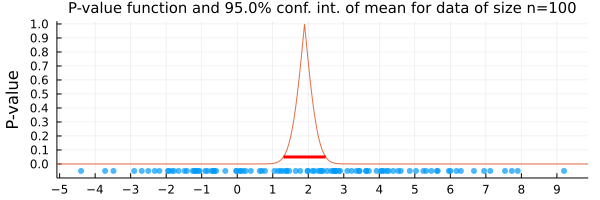

In [5]:
function pvalue_tdist(x̄, s², n, μ)
    t = (x̄ - μ)/√(s²/n)
    2ccdf(TDist(n-1), abs(t))
end

function pvalue_tdist(x, μ)
    x̄, s², n = mean(x), var(x), length(x)
    pvalue_tdist(x̄, s², n, μ)
end

function confint_tdist(x̄, s², n; α = 0.05)
    c = quantile(TDist(n-1), 1-α/2)
    [x̄ - c*√(s²/n), x̄ + c*√(s²/n)]
end

function confint_tdist(x; α = 0.05)
    x̄, s², n = mean(x), var(x), length(x)
    confint_tdist(x̄, s², n; α)
end

function show_confint_of_mean(x; μ = mean(x), α = 0.05)
    println("(P-value of hypothesis \"mean = $μ\") = ", pvalue_tdist(x, μ))
    println("($(100(1-α))% confidence interval of mean) = ", confint_tdist(x; α))
end

function plot_confint_of_mean(x; α = 0.05, plot_pvalues = false,
        xtick=-100:100, kwargs...)
    n = length(x)
    a, b = extrema(x)
    a, b = a - 0.05(b-a), b + 0.05(b-a)
    confidence_interval = confint_tdist(x; α)
    if plot_pvalues
        scatter(x, fill(-0.05, n); label="", msc=:auto, alpha=0.7)
        plot!(μ -> pvalue_tdist(x, μ), a, b; label="", c=2)
        plot!(confidence_interval, fill(α, 2); label="", lw=3, c=:red)
        plot!(; ylim=(-0.1, 1.02), ytick=0:0.1:1, yguide="P-value")
        title!("P-value function and $(100(1-α))% conf. int. of mean for data of size n=$n")
        plot!(; size=(600, 200), leftmargin=3Plots.mm)
    else
        scatter(x, fill(-0.05, n); label="", msc=:auto, alpha=0.7)
        plot!(confidence_interval, fill(0.06, 2); label="", lw=6, c=:red)
        plot!(; ylim=(-0.1, 0.12), yaxis=false, ytick=false)
        title!("$(100(1-α))% confidence interval of mean for data of size n=$n")
        plot!(; size=(600, 60))
    end
    plot!(; xlim=(a, b), xtick)
    plot!(; kwargs...)
end

x = rand(Normal(2, 3), 100)
show_confint_of_mean(x; μ = 1, α = 0.05)
plot_confint_of_mean(x; α = 0.05, plot_pvalues=true)

## 平均に関するP値と信頼区間

以下のようなことを行いたい.

(1) S市の中学3年生男子達から $n$ 人を無作為抽出して身長を測って得た数値のデータ $x_1,\ldots,x_n$ から, S市の中学3年生男子達の身長の平均値を推定したい.

(2) とある店で出されるフライドポテトの長さを $n$ 本分測って得た数値のデータ $x_1,\ldots,x_n$ から, その店で出されるフライドポテトの長さの平均値を推定したい.

このような推定を以下では __平均の推定__ と呼ぶことにする.

目標は平均の信頼区間の構成である.

そのためには, 検定と信頼区間の表裏一体性より, P値を適切に定義すればよい.

### 平均の検定で使用されるP値の定義(1) 中心極限定理経由で標準正規分布を使う場合

__データ:__　$n$ 個の実数値 $x_1,\ldots,x_n$.

データの標本平均と不偏分散をそれぞれ $\bar{x}$, $s^2$ と書く:

$$
\bar{x} = \frac{1}{n}\sum_{i=1}^n x_i, \quad
s^2 = \frac{1}{n-1}\sum_{i=1}^n \left(x_i - \bar{x}\right).
$$

__統計モデル:__　平均 $\mu$ と分散 $\sigma^2$ を持つ未知の確率分布 $D$ のサイズ $n$ の標本分布 $D^n$ を統計モデルとして採用する.

$D$ が連続分布でその確率密度函数が $p(x)$ と書かれるとき, 標本分布 $D^n$ の確率密度函数は次のように表される:

$$
p(x_1,\ldots,x_n) = p(x_1)\cdots p(x_n).
$$

$D$ が離散分布でその確率質量函数が $P(x)$ と書かれるとき, 標本分布 $D^n$ の確率質量函数は次のように表される:

$$
P(x_1,\ldots,x_n) = P(x_1)\cdots P(x_n).
$$

__この設定は, データ $x_1,\ldots,x_n$ がある母集団からの無作為抽出で得られた数値の列である場合に適切になる.__

未知だと想定されている分布 $D$ は母集団の分布モデル化になっていると考えている.

例えば, S市の中学3年生男子達から $n$ 人を無作為抽出して身長を測って得た数値のデータ $x_1,\ldots,x_n$ を用いた統計分析を行う場合には, モデルの確率分布 $D$ はS市の中学3年生男子達全員分の身長の数値の分布を近似していることを期待している.

仮に, S市の中学3年生男子達全員分の身長の数値の分布がすでに分かっているならば, 平均身長を推定するために無作為抽出を行う必要はない. 実際には未知であるからこそ無作為抽出で得たデータを使って統計分析をする必要が出て来る. だから, モデルの分布 $D$ は「未知の分布」であることにしておきたい.

確率分布 $D$ が未知であるという設定は, 分布 $D$ をある特定の分布(例えば正規分布)であると考えるのではなく, (適当な緩い条件を満たす)任意の分布であると考えることを意味している.

分布の平均 $\mu$, 分布の分散 $\sigma^2$ と無限個のパラメータ $\theta_3,\theta_4,\ldots$ を使って任意の分布を $D(\mu, \sigma, \theta_3, \theta_4, \ldots)$ とパラメトライズすると, この場合の統計モデルはこの無限個のパラメータを持つ確率分布 $D(\mu, \sigma^2, \theta_3, \theta_4, \ldots)$ であるということになる.

ただし, 以下の問題設定で興味があるのは平均パラメータ $\mu$ だけであり, 残りの $\sigma^2, \theta_3, \theta_4, \ldots$ は平均 $\mu$ に関する統計分析を邪魔するニューサンスパラメータ(nuisance parameters, 局外パラメータ, 攪乱パラメータ, 迷惑パラメータ)とみなされる.

ニューサンスパラメータの問題は二項分布モデルを使った比率の検定や信頼区間にはなかったので, これは新しい問題である.

以下では中心極限定理を使ってニューサンスパラメータの問題を回避する.

__検定したい仮説:__　$\mu = \mu_0$　($\mu_0$ は具体的な数値).

$X_1,\ldots,X_n$ は統計モデル $D^n$ に従う確率変数達であるとする. すなわち, $X_1,\ldots,X_n$ は独立な確率変数達であり, 各々がモデルの確率分布 $D$ に従っていると仮定する.

__標本平均に関する中心極限定理:__　中心極限定理によって, $n$ が十分に大きいならば, モデル内でランダムに生成された仮想的標本 $X_1,\ldots,X_n$ の標本平均

$$
\bar{X} = \frac{1}{n}\sum_{i=1}^n X_i
$$

は平均 $\mu$, 分散 $\sigma^2/n$ の正規分布に近似的に従う:

$$
\bar{X} \sim \Normal\left(\mu, \sqrt{\sigma^2/n}\right), \ \text{approximately}.
$$

__不偏分散に関する大数の法則:__　大数の法則より, $n$ を十分に大きくすると, モデルの確率分布 $D$ の分散 $\sigma^2$ の値は, モデル内でランダムに生成された仮想的標本 $X_1,\ldots,X_n$ の不偏分散(不偏推定量になるように補正された標本分散)

$$
S^2 = \frac{1}{n-1}\sum_{i=1}^n \left(X_i - \bar{X}\right)
$$

で近似される:

$$
S^2 \approx \sigma^2.
$$

__検定で使われる $T$ 統計量:__　以上の状況の下で, $T$ 統計量を

$$
T(\mu) := \frac{\bar{X} - \mu}{\sqrt{S^2/n}} \approx
\frac{\bar{X} - \mu}{\sqrt{\sigma^2/n}} \sim
\Normal(0,1), \ \text{approximately}.
$$

と定める. このとき $T(\mu)$ は近似的に標準正規分布に従う:

$$
T(\mu) \sim \Normal(0,1), \ \text{approximately}.
$$

データの $t$ 値を次のように定める:

$$
t(\mu) := \frac{\bar{x} - \mu}{\sqrt{s^2/n}}.
$$

__P値の定義:__　仮説 $\mu = \mu_0$ 下の統計モデル内で $|T(\mu_0)| \ge |t(\mu_0)|$ となる確率を, 標準正規分布に従ってランダムに生成される値の絶対値が $|t(\mu_0)|$ 以上になる確率として近似的に求めて, その値をデータ $x_1,\ldots,x_n$ に関する仮説 $\mu = \mu_0$ のP値として採用する. そのP値を次のように書く:

$$
\pvalue_{\Normal}(\bar{x}, s^2|n, \mu=\mu_0) = 
2(1 - \cdf(\Normal(0,1), |t(\mu_0)|)).
$$

### 標本平均と不偏分散に関する中心極限定理と大数の法則の可視化

前節のP値の定義では, 中心極限定理によって, 平均 $\mu$, 分散 $\sigma^2$ を持つ確率分布 $D$ のサイズ $n$ の標本 $X_1,\ldots,X_n$ (独立同分布な確率変数達になる)の標本平均 $\bar{X}$ (確率変数になる)が, $n$ が大きなとき, 平均 $\mu$, 分散 $\sigma^2/n$ を持つ正規分布に __近似的に__ 従うという結果(中心極限定理)を使った.

そしてさらに, 大数の法則によって, $n$ を大きくすると, $X_1,\ldots,X_n$ の不偏分散が $\sigma$ を近似するようになることも使った.

前節のP値に定義が意味を持つためには, $T(\mu) = (\bar{X} - \mu)/\sqrt{S^2/n}$ が近似的に標準正規分布に従うことが必要である.

以下でそれを様々な確率分布 $D$ について確認してみよう. 


以下では, 平均 $\mu$ と分散 $\sigma^2$ を持つ様々な確率分布 $D$ の標本分布 $D^n$ における以下の3つの確率変数の分布のグラフを描く:

$$
Z(\mu) = \frac{\bar{X}-\mu}{\sqrt{\sigma^2/n}}, \quad
\sqrt{\frac{S^2}{\sigma^2}}, \quad
T(\mu) = \frac{\bar{X}-\mu}{\sqrt{S^2/n}} =
\frac{Z(\mu)}{\sqrt{S^2/\sigma^2}}.
$$

$n$ を大きくして行くと, 大数の法則より $\sqrt{S^2/\sigma^2}$ の分布は $1$ に集中して行き, 中心極限定理より $Z(\mu)$ の分布は標準正規分布に近付いて行く.

__特に, 確率分布 $D$ の種類ごとに, $T(\mu)$ の分布の標準正規分布による近似の誤差の大きさが違うことに注目せよ.__

__正規分布の場合__

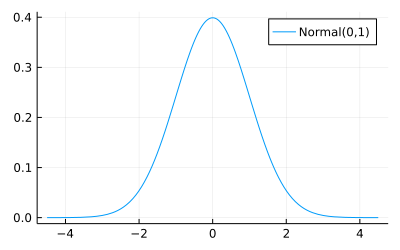

In [6]:
plot(Normal(), -4.5, 4.5; label="Normal(0,1)")

skewness = 0.0,  kurtosis = 0.0


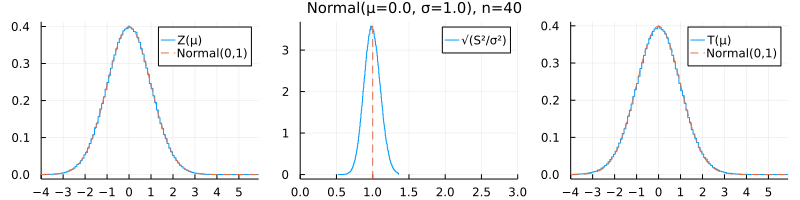

In [7]:
plot_T(Normal(), 40)

__一様分布の場合__

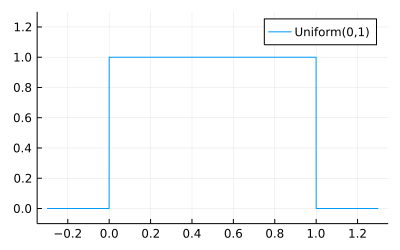

In [8]:
plot(Uniform(), -0.3, 1.3; label="Uniform(0,1)", ylim=(-0.1, 1.3))

skewness = 0.0,  kurtosis = -1.2


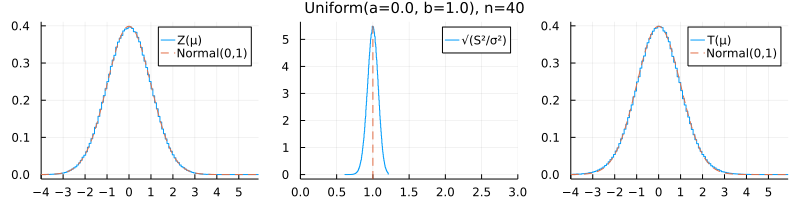

In [9]:
plot_T(Uniform(), 40)

__Laplace分布の場合__

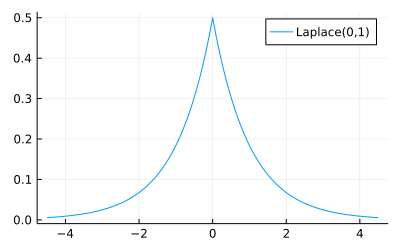

In [10]:
plot(Laplace(), -4.5, 4.5; label="Laplace(0,1)")

skewness = 0.0,  kurtosis = 3.0


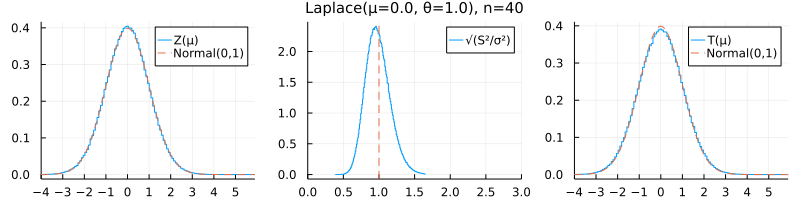

In [11]:
plot_T(Laplace(), 40)

__ガンマ分布の場合__

ガンマ分布は左右非対称な分布の典型例である.

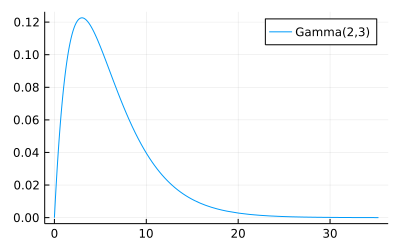

In [12]:
plot(Gamma(2,3); label="Gamma(2,3)")

skewness = 1.414213562373095,  kurtosis = 3.0


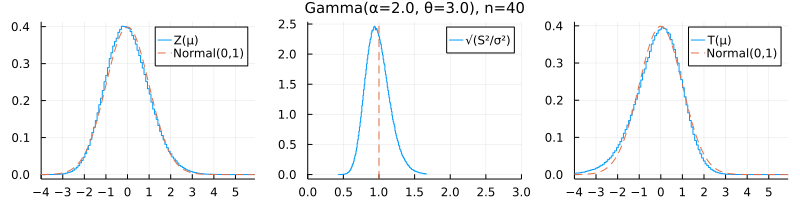

In [13]:
plot_T(Gamma(2,3), 40)

skewness = 1.414213562373095,  kurtosis = 3.0


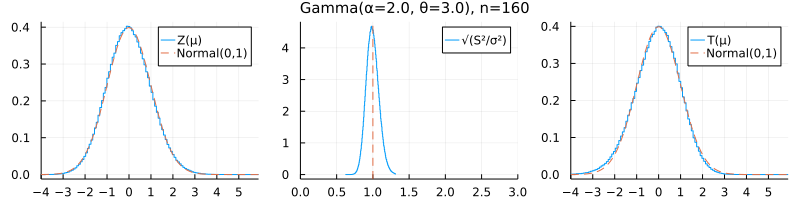

In [14]:
plot_T(Gamma(2,3), 160)

skewness = 1.414213562373095,  kurtosis = 3.0


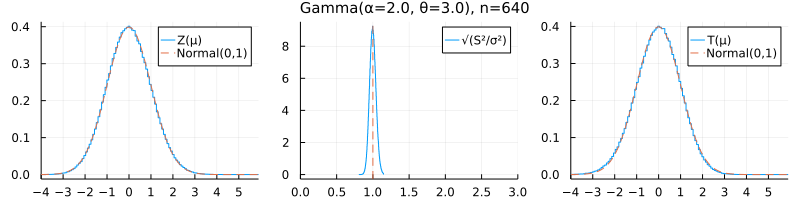

In [15]:
plot_T(Gamma(2,3), 640)

__対数正規分布の場合__

対数正規分布は左右非対称でかつ __外れ値が出易い__ 分布の典型例である.

このような場合は $n$ を非常に大きくしないと近似の精度が高まらない.

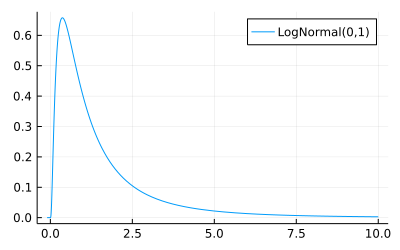

In [16]:
plot(LogNormal(), -0.1, 10; label="LogNormal(0,1)")

skewness = 6.184877138632554,  kurtosis = 110.9363921763115


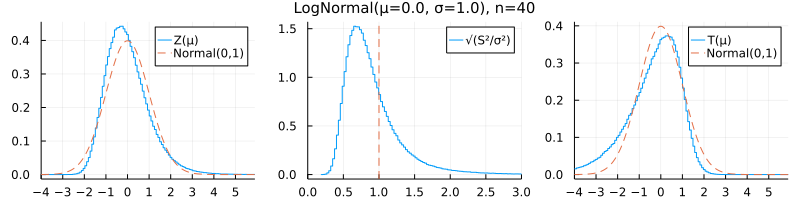

In [17]:
plot_T(LogNormal(), 40)

skewness = 6.184877138632554,  kurtosis = 110.9363921763115


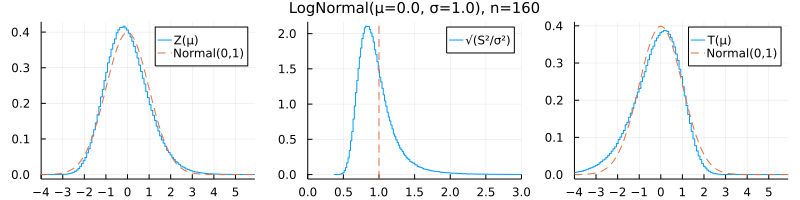

In [18]:
plot_T(LogNormal(), 160)

skewness = 6.184877138632554,  kurtosis = 110.9363921763115


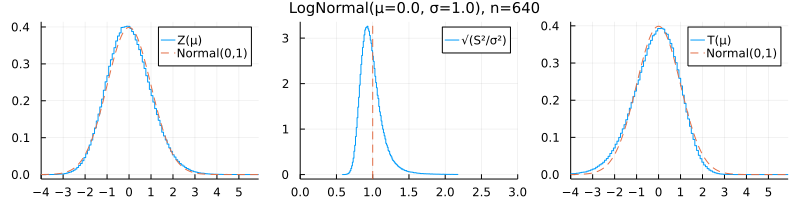

In [19]:
plot_T(LogNormal(), 640)

skewness = 6.184877138632554,  kurtosis = 110.9363921763115


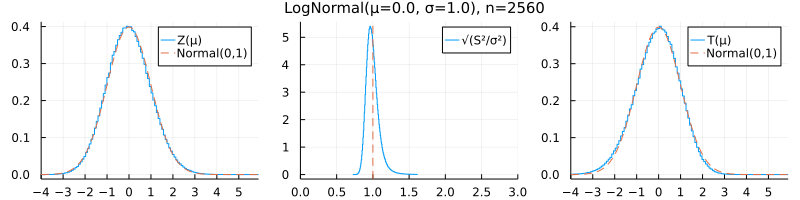

In [20]:
plot_T(LogNormal(), 2560)

この例から, 左右非対称で外れ値を含む母集団分布からの無作為抽出で得たデータを扱う場合には, 中心極限定理を使った近似を用いることは要注意であることがわかる.

__注意:__ $X\sim D$ と仮定する. 一般に, 分布 $D$ の歪度(わいど, skewness)と尖度(せんど, kurtosis, 過剰尖度, excessive kurtosis)をそれぞれ

$$
\bk_3 = E\left[\left(\frac{X-\mu}{\sigma}\right)^3\right], \quad
\bk_4 = E\left[\left(\frac{X-\mu}{\sigma}\right)^4\right] - 3
$$

と書く. ($D$ が正規分布の場合には $\bk_3 = \bk_4 = 0$ となる.)

このとき, $\bk_4 \ge \bk_3^2 - 2$ および以下が成立することを示せる:

$$
\begin{aligned}
&
\begin{bmatrix}
E[\bar{X}] \\
E[S^2] \\
\end{bmatrix} =
\begin{bmatrix}
\mu \\
\sigma^2 \\
\end{bmatrix},
\\ &
\begin{bmatrix}
\var(\bar{X}) & \cov(\bar{X}, S^2) \\
\cov(\bar{X}, S^2) & \var(S^2) \\
\end{bmatrix} =
\frac{1}{n}
\begin{bmatrix}
\sigma^2 & \sigma^3\bk_3 \\
\sigma^3\bk_3 & \sigma^4(\bk_4 + 2/(1-1/n)) \\
\end{bmatrix}.
\end{aligned}
$$

そして, 多変量分布の中心極限定理(これはこのノート群では証明していないが, 1変量の場合と同じ方法で証明される)によって, $n$ が大きなとき, $\bar{X}, S^2$ の同時分布は, それらを平均と分散共分散行列に持つ2変量正規分布で近似される. $n\to\infty$ で分散共分散行列が $0$ に収束することから, $(\bar{X}, S^2)$ の分布が $(\mu, \sigma^2)$ に集中して行くこともわかる(大数の法則).

この一般的な結果の視覚化については[「標本分布について」のノート](https://nbviewer.org/github/genkuroki/Statistics/blob/master/2022/04%20Distribution%20of%20samples.ipynb)を参照せよ.  そこで詳しく解説されている結果と視覚化は「平均の検定や信頼区間」のような統計学における基本を理解するためにかなり重要なことなのだが, 入門的な教科書ではほとんど説明されていない.  理解を深めるために貴重な解説になっていると思われるので是非とも繰り返し参照して欲しい.

### 問題: 他の様々な分布について T(μ) の分布を確認

上の例以外の分布についても $T(\mu)$ の分布がどうなっているかを確認せよ.

__ヒント:__ [「標本分布について」のノート](https://nbviewer.org/github/genkuroki/Statistics/blob/master/2022/04%20Distribution%20of%20samples.ipynb)を参照せよ.

__次節で使う $z_{\alpha/2}$ の値の例:__ $\alpha=5\%, 1\%, 0.1\%$ のそれぞれについて,

In [21]:
@. round(quantile(Normal(), 1 - (0.05, 0.01, 0.001) / 2); digits=4)

(1.96, 2.5758, 3.2905)

### P値の定義(1)の標準正規分布を使う場合に対応する平均の信頼区間

有意水準を $0\le\alpha\le 1$ と書き, 標準正規分布において $z_{\alpha/2}$ 以上になる確率は $\alpha/2$ になると仮定する:

$$
z_{\alpha/2} = \quantile(\Normal(0,1), 1 - \alpha/2).
$$

例えば,

$$
z_{5\%/2} \approx 1.9600, \quad
z_{1\%/2} \approx 2.5758, \quad
z_{0.1\%/2} \approx 3.2905.
$$

P値函数 $\pvalue_{\Normal}(\bar{x}, s^2|n, \mu=\mu_0) = 2(1 - \cdf(\Normal(0,1), |t(\mu_0)|))$ に対応する信頼度 $1-\alpha$ の信頼区間は次のようになる:

$$
\confint_{\Normal}(\bar{x}, s^2|n, \mu=\mu_0) =
\left[
\bar{x} - z_{\alpha/2} \sqrt{s^2/n},\;
\bar{x} + z_{\alpha/2} \sqrt{s^2/n}
\right].
$$

__証明:__ 検定と信頼区間の表裏一体性より, P値函数 $\pvalue_{\Normal}(\bar{x}, s^2|n, \mu=\mu_0)$ に対応する信頼度 $1-\alpha$ の信頼区間は次のように定義されるのであった:

$$
\confint_{\Normal}(\bar{x}, s^2|n, \mu=\mu_0) =
\{\, \mu_0\in\R \mid \pvalue_{\Normal}(\bar{x}, s^2|n, \mu=\mu_0) \ge \alpha\,\}.
$$

そして,

$$
\begin{aligned}
&
\pvalue_{\Normal}(\bar{x}, s^2|n, \mu=\mu_0) \ge \alpha
\\ &\iff
1 - \cdf(\Normal(0,1), |t(\mu_0)|)) \ge \alpha/2
\\ &\iff
|t(\mu_0)| = \frac{|\bar{x} - \mu_0|}{\sqrt{s^2/n}} \le z_{\alpha/2}
\\ &\iff
\bar{x} - z_{\alpha/2} \sqrt{s^2/n} \le \mu_0 \le
\bar{x} + z_{\alpha/2} \sqrt{s^2/n}.
\end{aligned}
$$

これより, P値の定義(1)に対応する平均の信頼区間が上のようになることがわかった.

__証明終__

### 平均の検定で使用されるP値の定義(2) さらに t 分布を使う場合

分布 $D$ が左右対称の分布ならば $n=10$ のようなかなり小さな $n$ で中心極限定理による近似の誤差は非常に小さくなる場合がある.  しかし, そういう場合であっても, 大数の法則を使った不偏分散 $S^2$ による $\sigma^2$ の近似の精度は低いままの場合がある.

そういう場合の補正を $t$ 分布を使って行う処方箋を採用しよう.

__統計モデルとして正規分布の標本分布を仮定:__　以下では, 統計モデルとして, 平均 $\mu$, 分散 $\sigma^2$ を持つ正規分布のサイズ $n$ の標本分布を採用する.  その確率密度函数は次のように表される:

$$
p(x_1,\ldots,x_n|\mu,\sigma^2) =
\frac{1}{(2\pi\sigma^2)^{n/2}}
\exp\left(-\frac{1}{2\sigma^2}\sum_{i=1}^n (x_i - \mu)^2\right).
$$

$X_1,\ldots,X_n$ はこの統計モデルに従う確率変数達であるとし, それらの標本平均と不偏分散をそれぞれ $\bar{X}$, $S^2$ と表す.

__X̄とS²の同時分布:__　標本平均と不偏分散

$$
\bar{x} = \frac{1}{n}\sum_{i=1}^n x_i, \quad
s^2 = \frac{1}{n}\sum_{i=1}^n (x_i - \bar{x})^2
$$

を使うと, 

$$
\sum_{i=1}^n (x_i - \mu)^2 =
\sum_{i=1}^n ((x_i - \bar{x}) (\bar{x} - \mu))^2 =
(n-1)s^2 + n(\bar{x} - \mu))^2.
$$

なので, 

$$
p(x_1,\ldots,x_n|\mu,\sigma^2) =
\frac{1}{(2\pi\sigma^2)^{n/2}}
\exp\left(-\frac{1}{2}\frac{(n-1)s^2}{\sigma^2} - \frac{(\bar{x} - \mu)^2}{2\sigma^2/n}\right).
$$

このことから, $\bar{X}, S^2$ は独立な確率変数であり, $\bar{X}$ は平均 $\mu$, 分散 $\sigma^2/n$ の正規分布に従い, $(n-1)S^2/\sigma^2$ は自由度 $n-1$ のχ²分布に従うことを示せる:

$$
\bar{X} \sim \Normal\left(\mu, \sqrt{\sigma^2/n}\right), \quad
\frac{(n-1)S^2}{\sigma^2} \sim \Chisq(n-1).
$$

詳しくは「標本分布について」のノートの「正規分布の標本分布の場合」の節を参照せよ.  自由度 $n-1$ のχ²分布の密度函数を作るために必要な, $u=s^2$ とおいたときの因子 $u^{(n-1)/2-1} は

$$
dy_1\cdots dy_{n-1} \propto
\left(\sqrt{u}\right)^{n-2}\,d\sqrt{u}\,d\theta \propto
u^{(n-1)/2-1}\,du\,d\theta
$$

のような計算で出て来る. ここで $d\theta$ は $n-2$ 次元単位球面の微小面積要素である.

__T統計量が従う分布:__　ゆえに, $T$ 統計量

$$
T(\mu) = \frac{\bar{X} - \mu}{\sqrt{S^2/n}}
$$

は自由度 $n-1$ の $t$ 分布に従う:

$$
T(\mu) \sim \TDist(n-1).
$$

詳しくは, 「正規分布の標本分布から自然にt分布に従う確率変数が得られること」を参照せよ.

__注意:__ 自由度が大きな $t$ 分布は標準正規分布とほぼ同じになるので, この結果はP値の定義(1)で使った結果と整合的であり, この結果が意味を持つのは $n$ が大きくない場合にのみ意味を持つ.  実践的には $n$ が十分に大きな場合には $\TDist(n-1)$ を標準正規分布で置き換えてよい.

__P値の定義:__　仮説 $\mu = \mu_0$ の下で $|T(\mu_0)| \ge |t(\mu_0)|$ となる確率を, 自由度 $n-1$ の $t$ 分布に従ってランダムに生成される値の絶対値が $|t(\mu_0)|$ 以上になる確率として正確に求めて, その値をデータ $x_1,\ldots,x_n$ に関する仮説 $\mu = \mu_0$ のP値として採用する. そのP値を次のように書く:

$$
\pvalue_{\TDist}(\bar{x}, s^2|n, \mu=\mu_0) = 
2(1 - \cdf(\TDist(n-2), |t(\mu_0)|)).
$$

このP値は $n$ が大きな場合には定義(1)のP値 $\pvalue_{\Normal}(\bar{x}, s^2|n, \mu=\mu_0)$ と近似的に一致する.  ゆえに, P値の定義(1)を使うことを止めて, こちらの定義(2)の方だけを使うことにしても害がないと考えられる.

__我々はこれ以後こちらのP値の定義のみを使用する.__

__注意:__ ただし, こちらの定義(2)のP値は先の定義(1)のP値よりも少し大きくなり, 定義(2)の場合の信頼区間は定義(1)の場合の信頼区間よりも少し広くなる.

In [22]:
df = 10:10:100
α = [0.05, 0.01, 0.001]
z = @. round(quantile(Normal(), 1-α'/2); digits=4)
t = @. round(quantile(TDist(df), 1-α'/2); digits=4)
table_of_t = DataFrame(
    df = Any[df; Inf],
    var"α = 5%" = [t[:,1]; z[1]],
    var"α = 1%" = [t[:,2]; z[2]],
    var"α = 0.1%" = [t[:,3]; z[3]],
)

,df,α = 5%,α = 1%,α = 0.1%
,Any,Float64,Float64,Float64
1,10,2.2281,3.1693,4.5869
2,20,2.086,2.8453,3.8495
3,30,2.0423,2.75,3.646
4,40,2.0211,2.7045,3.551
5,50,2.0086,2.6778,3.496
6,60,2.0003,2.6603,3.4602
7,70,1.9944,2.6479,3.435
8,80,1.9901,2.6387,3.4163
9,90,1.9867,2.6316,3.4019


In [23]:
quantile(TDist(30), 1-0.05/2) / quantile(Normal(), 1-0.05/2)

1.0419948899114568

### 標本分布におけるT統計量の分布の視覚化

前節では, $t$ 分布を使用することによって, 分布 $D$ が左右対称でおとなしめもしくは正規分布に非常に近い分布でかつ $n$ が小さな場合に精度が高まることを期待してP値を再定義した.

その期待が実際に正しそうなことを確認するために, 以下では再度 $T(\mu)$ の分布の視覚化を行う.

そのとき, 非対称な分布の場合に $n$ を大きくしたとき, $t$ 分布の使用に害がないことも確認しておこう.

さらに, $\sqrt{S^2/\sigma^2}$ の分布と $\sqrt{\Chisq(n-1)/(n-1)}$ の比較も同時に行うことにしよう. ($X\sim\Chisq(\nu)$ のとき $\sqrt{X}$ が従う分布を $\Chi(\nu)$ と書き __χ分布__ と呼ぶ.)

以下では, 平均 $\mu$ と分散 $\sigma^2$ を持つ様々な確率分布 $D$ の標本分布 $D^n$ における以下の3つの確率変数の分布のグラフを描く:

$$
Z(\mu) = \frac{\bar{X}-\mu}{\sqrt{\sigma^2/n}}, \quad
\sqrt{\frac{S^2}{\sigma^2}}, \quad
T(\mu) = \frac{\bar{X}-\mu}{\sqrt{S^2/n}} =
\frac{Z(\mu)}{\sqrt{S^2/\sigma^2}}.
$$

__正規分布の場合__

これは理想的(過ぎる)場合である.

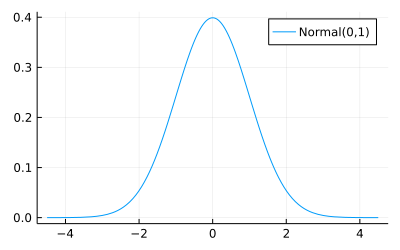

In [24]:
plot(Normal(), -4.5, 4.5; label="Normal(0,1)")

skewness = 0.0,  kurtosis = 0.0


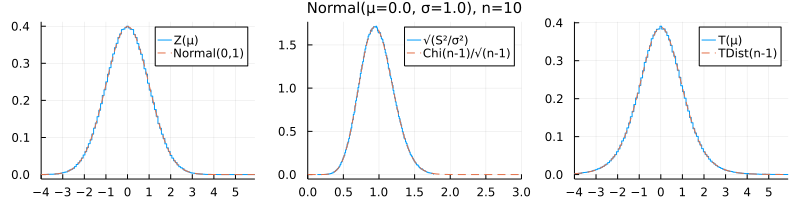

In [25]:
plot_T(Normal(), 10, plot_chi=true, plot_t=true)

__一様分布の場合__

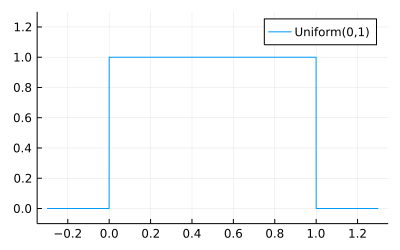

In [26]:
plot(Uniform(), -0.3, 1.3; label="Uniform(0,1)", ylim=(-0.1, 1.3))

skewness = 0.0,  kurtosis = -1.2


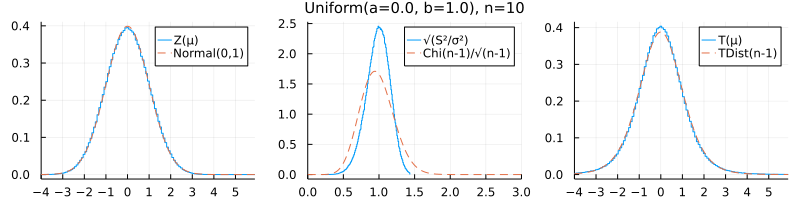

In [27]:
plot_T(Uniform(), 10, plot_chi=true, plot_t=true)

skewness = 0.0,  kurtosis = -1.2


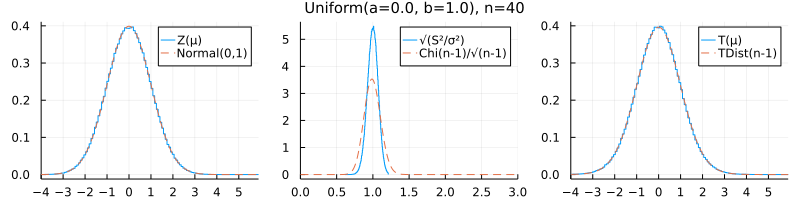

In [28]:
plot_T(Uniform(), 40, plot_chi=true, plot_t=true)

skewness = 0.0,  kurtosis = -1.2


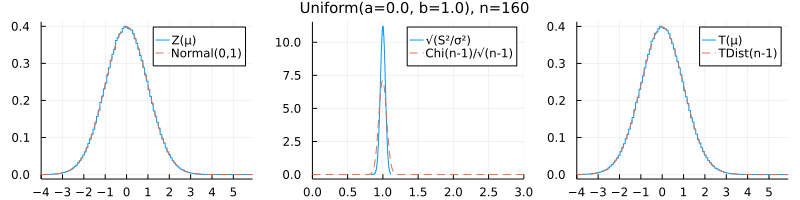

In [29]:
plot_T(Uniform(), 160, plot_chi=true, plot_t=true)

上の例を見れば, $T(\mu)$ の分布が $t$ 分布でよく近似されている状況であっても, $(n-1)S^2/\sigma^2$ の分布がχ²分布で近似されていると考えてはいけないことがわかる.  この点は以下でも同様である.

だから, __正規分布の標本分布モデルにおいて成り立っている $(n-1)S^2/\sigma^2 \sim \Chisq(n-1)$ を用いて, 分散 $\sigma^2$ の区間推定を行うことは大きなリスクが伴う.__

平均の区間推定と違って, __分散の区間推定は非常に難しい.__

__Laplace分布の場合__

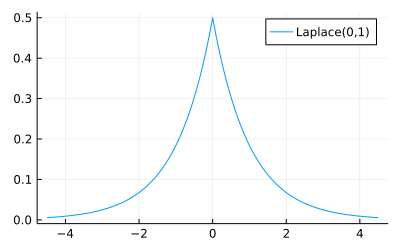

In [30]:
plot(Laplace(), -4.5, 4.5; label="Laplace(0,1)")

skewness = 0.0,  kurtosis = 3.0


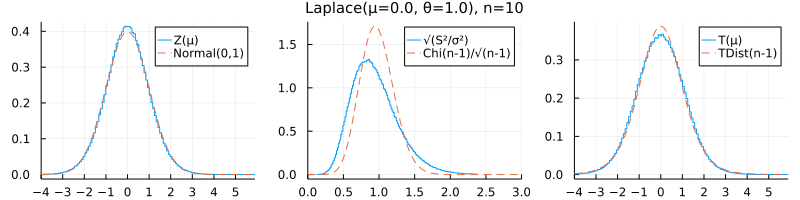

In [31]:
plot_T(Laplace(), 10, plot_chi=true, plot_t=true)

skewness = 0.0,  kurtosis = 3.0


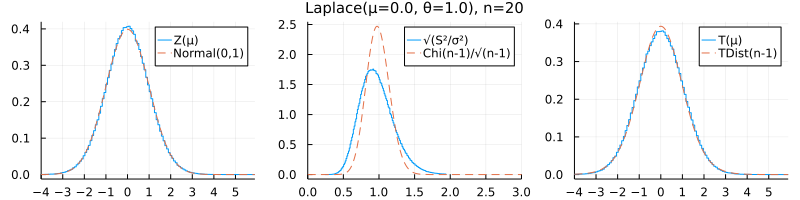

In [32]:
plot_T(Laplace(), 20, plot_chi=true, plot_t=true)

skewness = 0.0,  kurtosis = 3.0


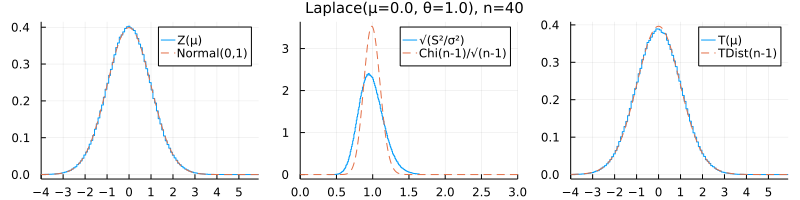

In [33]:
plot_T(Laplace(), 40, plot_chi=true, plot_t=true)

__ガンマ分布の場合__

ガンマ分布は左右非対称な分布の典型例である.

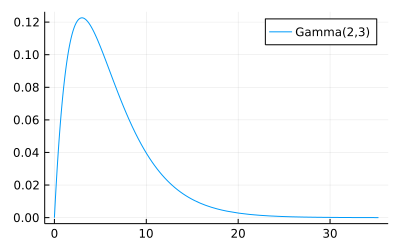

In [34]:
plot(Gamma(2,3); label="Gamma(2,3)")

skewness = 1.414213562373095,  kurtosis = 3.0


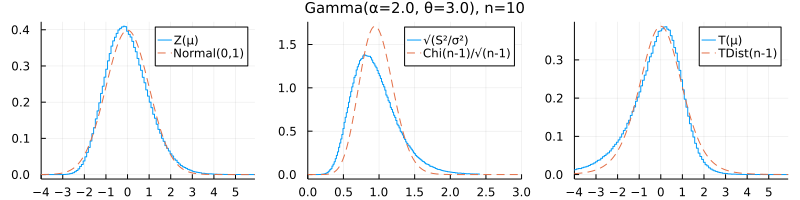

In [35]:
plot_T(Gamma(2,3), 10, plot_chi=true, plot_t=true)

skewness = 1.414213562373095,  kurtosis = 3.0


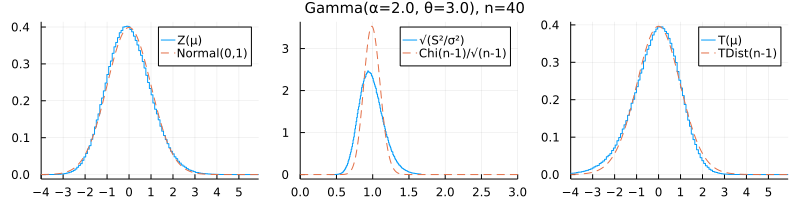

In [36]:
plot_T(Gamma(2,3), 40, plot_chi=true, plot_t=true)

skewness = 1.414213562373095,  kurtosis = 3.0


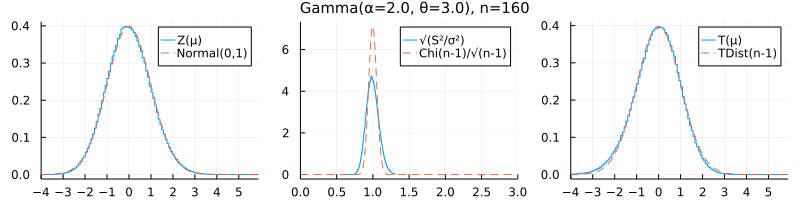

In [37]:
plot_T(Gamma(2,3), 160, plot_chi=true, plot_t=true)

skewness = 1.414213562373095,  kurtosis = 3.0


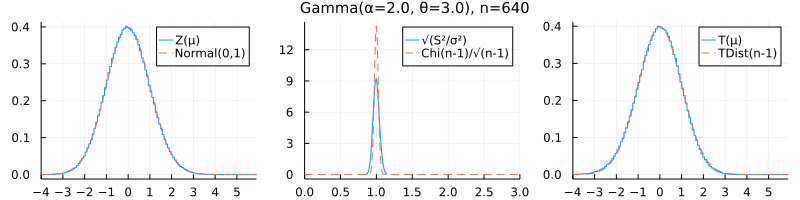

In [38]:
plot_T(Gamma(2,3), 640, plot_chi=true, plot_t=true)

__対数正規分布の場合__

対数正規分布は左右非対称でかつ __外れ値が出易い__ 分布の典型例である.

このような場合は $n$ を非常に大きくしないと近似の精度が高まらない.

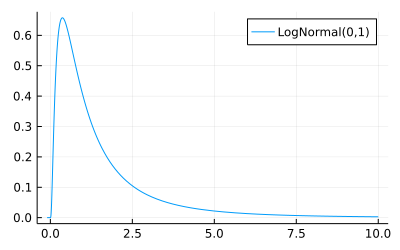

In [39]:
plot(LogNormal(), -0.1, 10; label="LogNormal(0,1)")

skewness = 6.184877138632554,  kurtosis = 110.9363921763115


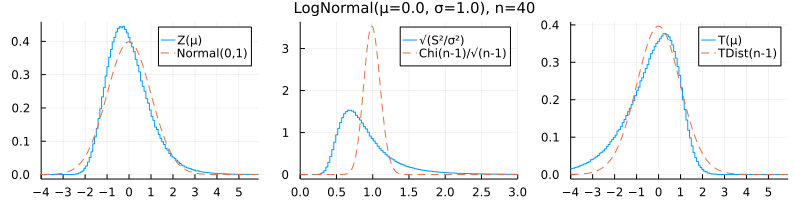

In [40]:
plot_T(LogNormal(), 40, plot_chi=true, plot_t=true)

skewness = 6.184877138632554,  kurtosis = 110.9363921763115


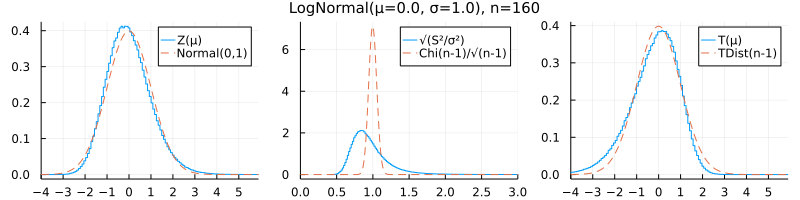

In [41]:
plot_T(LogNormal(), 160, plot_chi=true, plot_t=true)

skewness = 6.184877138632554,  kurtosis = 110.9363921763115


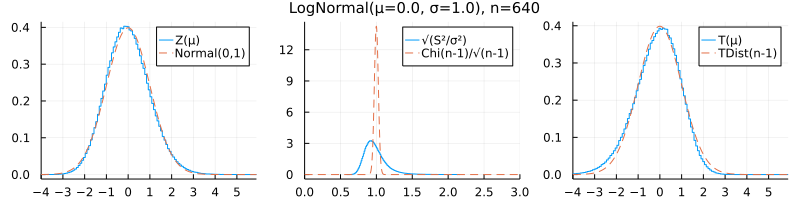

In [42]:
plot_T(LogNormal(), 640, plot_chi=true, plot_t=true)

skewness = 6.184877138632554,  kurtosis = 110.9363921763115


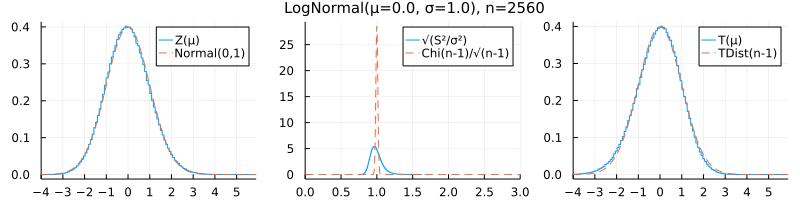

In [43]:
plot_T(LogNormal(), 2560, plot_chi=true, plot_t=true)

この例から, 左右非対称で外れ値を含む母集団分布からの無作為抽出で得たデータを扱う場合には, 中心極限定理を使った近似を用いることは要注意であることがわかる.

### 分布の対数の標本分布のT統計量の視覚化

データの数値 $x_i$ がすべて正の値の場合には, $y_i = \log x_i$ と対数を取った後に, 「分布の対数の平均が $\lambda_0$ である」という仮説を扱った方が誤差が減る場合がある.

より一般に対数に限らず, データを適切な座標に変換してから統計分析にかけた方が誤差が小さくなる場合がある.

__対数正規分布の場合__

対数正規分布に従う確率変数の対数は定義より正規分布に従う.  この場合には正値のデータの対数を取ってから計算することの効果は自明に絶大になる.  (この場合は自明過ぎてあまり意味がない.)

skewness = 6.184877138632554,  kurtosis = 110.9363921763115


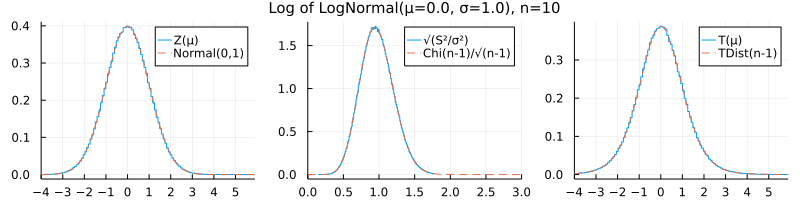

In [44]:
plot_T(LogNormal(), 10, plot_chi=true, plot_t=true, logsample=true)

__ガンマ分布の場合__

__ガンマ分布とその対数の密度函数達__

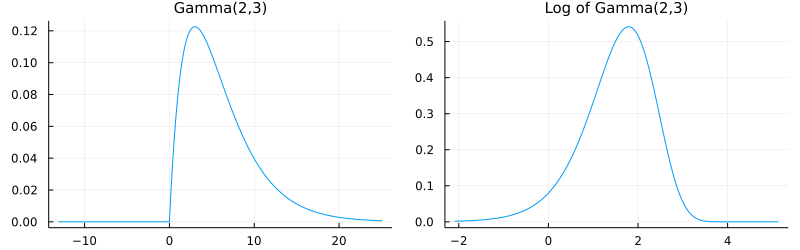

In [45]:
μ, σ = mean(Gamma(2, 3)), std(Gamma(2, 3))
P = plot(x -> pdf(Gamma(2, 3), x), μ-4.5σ, μ+4.5σ; label="", title="Gamma(2,3)")
μ, σ = logmean(Gamma(2, 3)), logstd(Gamma(2, 3))
Q = plot(x -> pdflog(Gamma(2, 3), x), μ-4.5σ, μ+4.5σ; label="", title="Log of Gamma(2,3)")
plot(P, Q; size=(800, 250))

__対数を取る前__

skewness = 1.414213562373095,  kurtosis = 3.0


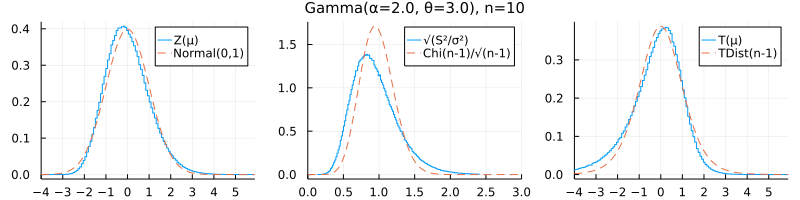

In [46]:
plot_T(Gamma(2,3), 10, plot_chi=true, plot_t=true)

__対数を取った後__

skewness = 1.414213562373095,  kurtosis = 3.0


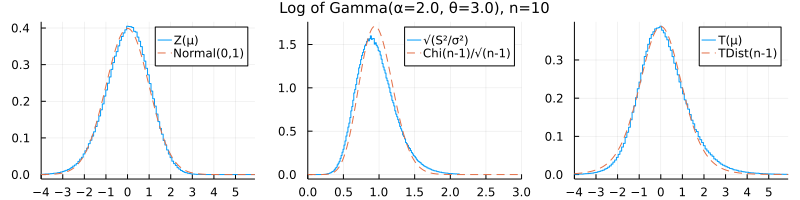

In [47]:
plot_T(Gamma(2,3), 10, plot_chi=true, plot_t=true, logsample=true)

よく見ないと分からないかもしれないが, 対数を取った後の方が近似の精度が上がっていることが分かる.

以上では対数を取ることによって誤差を減らすことができる場合があることを示したが, より一般に, データを適切な座標に変換してから統計分析にかけた方が誤差が小さくなる場合がある.

__データの数値の生成のされ方に関してなにがしかの知識がある場合には, その知識をうまく統計分析の枠組みに取り入れた方が誤差が小さな分析が可能になる可能性が増える.__

### 平均に関するP値の使い方

母集団からの無作為抽出で得たサイズ $n$ のデータ $x_1,\ldots,x_n$ の標本平均と不偏分散をそれぞれ $\bar{x}$, $s^2$ と書くとき, そのデータの数値に関する仮説「平均は $\mu = \mu_0$ である」のP値は

　データの数値と仮説「平均は $\mu = \mu_0$ である」の整合性の指標
 
として使われる.
 
ただし, P値を計算するときに用いた統計モデルや近似がうまく行っているというような仮定が不適切なことが原因で整合性の指標をおかしな値になってしまうリスクにも十分に配慮しなければいけない. さらに, データの取得法に問題があったことを疑わなければいけない場合は珍しくない(むしろ普通である).  統計分析の妥当性を確保するためには, 様々な可能性を疑って, 問題を一つひとつ丁寧に潰して行く必要がある.
 
有意水準と呼ばれる閾値 $0\le \alpha\le 1$ を最初に決めておいて(目的に合わせて小さな正の値に取る), P値が有意水準 $\alpha$ 未満になったときに,

　データの数値と仮説「平均は $\mu = \mu_0$ である」のあいだに整合性が無さすぎる
 
 と判定し,
 
　データの数値によって仮説「平均は $\mu = \mu_0$ である」が __棄却__ された
 
 と言うことがある.  このような手続きを __検定__(testing, test)と呼ぶのであった.

### P値の定義(2)のt分布を使う場合に対応する平均の信頼区間

有意水準を $0\le\alpha\le 1$ と書き, 自由度 $\nu$ の $t$ 分布において $t_{\alpha/2}(\nu)$ 以上になる確率は $\alpha/2$ になると仮定する:

$$
t_{\alpha/2,\nu} = \quantile(\TDist(\nu), 1 - \alpha/2).
$$

例えば,

$$
t_{5\%/2,10} \approx 2.2281, \quad
t_{5\%/2,20} \approx 2.0860, \quad
t_{5\%/2,30} \approx 2.0423.
$$

自由度を大きくする極限では, $t_{5\%/2,\infty} = z_{5\%/2} \approx 1.9600$ となる.  $t_{5\%/2,30} \approx 2.0423$ はその値よりも $4.2\%$ 程度大きい. (信頼区間もその割合で広くなる.)

P値 $\pvalue_{\TDist}(\bar{x}, s^2|n, \mu=\mu_0) = 2(1 - \cdf(\TDist(n-2), |t(\mu_0)|))$ に対応する信頼度 $1-\alpha$ の信頼区間は次のようになる:

$$
\confint_{\TDist}(\bar{x}, s^2|n, \mu=\mu_0) =
\left[
\bar{x} - t_{\alpha/2,n-1} \sqrt{s^2/n},\;
\bar{x} + t_{\alpha/2,n-1} \sqrt{s^2/n}
\right].
$$

これと $\confint_{\Normal}(\bar{x}, s^2|n, \mu=\mu_0)$ の違いは $z_{\alpha/2}$ を $t_{\alpha/2, n-1}$ に置き換える分の違いしかない.

証明もP値の定義(1)の場合と完全に同様である. 標準正規分布を $t$ 分布で置き換えるだけでよい.

__証明:__ 検定と信頼区間の表裏一体性より, P値函数 $\pvalue_{\TDist}(\bar{x}, s^2|n, \mu=\mu_0)$ に対応する信頼度 $1-\alpha$ の信頼区間は次のように定義されるのであった:

$$
\confint_{\TDist}(\bar{x}, s^2|n, \mu=\mu_0) =
\{\, \mu_0\in\R \mid \pvalue_{\TDist}(\bar{x}, s^2|n, \mu=\mu_0) \ge \alpha\,\}.
$$

そして,

$$
\begin{aligned}
&
\pvalue_{\TDist}(\bar{x}, s^2|n, \mu=\mu_0) \ge \alpha
\\ &\iff
1 - \cdf(\TDist(n-1), |t(\mu_0)|)) \ge \alpha/2
\\ &\iff
|t(\mu_0)| = \frac{|\bar{x} - \mu_0|}{\sqrt{s^2/n}} \le t_{\alpha/2,n-1}
\\ &\iff
\bar{x} - t_{\alpha/2,n-1} \sqrt{s^2/n} \le \mu_0 \le
\bar{x} + t_{\alpha/2,n-1} \sqrt{s^2/n}.
\end{aligned}
$$

これより, P値の定義(2)に対応する平均の信頼区間が上のようになることがわかった.

__証明終__

## 平均に関するP値と信頼区間の計算例

### 平均に関するP値と信頼区間の計算の仕方

(0) 前提

__有意水準:__ $0 < \alpha < 1$.

__検定したい仮説:__ 平均は $\mu=\mu_0$ である.

__データの数値:__ $x_1,\ldots,x_n$.

母集団からの無作為抽出(または同分布の独立試行)で得られたサイズ $n$ のデータの数値 $x_1,\ldots,x_n$ が得られていると仮定する.

__計算したい信頼区間:__ 平均 $\mu$ に関する信頼度 $1-\alpha$ の信頼区間.

(1) データの数値の標本平均 $\bar{x}$ と不偏分散 $s^2$ を計算する:

$$
\bar{x} = \frac{1}{n}\sum_{i=1}^n x_i, \quad
s^2 = \frac{1}{n-1}\sum_{i=1}^n (x_i - \bar{x})^2.
$$

(2) データの数値の数値に関する仮説「平均は $\mu=\mu_0$ である」の $t$ 値 $t = t(\mu_0)$ を計算する:

$$
t = t(\mu_0) = \frac{\bar{x} - \mu_0}{\sqrt{s^2/n}}.
$$

(3) データの数値に関する仮説「平均は $\mu=\mu_0$ である」のP値を自由度 $n-1$ の $t$ 分布に従ってランダムに生成される値の絶対値が データの数値の $t$ 値の絶対値以上になる確率として求める:

$$
(\text{仮説「平均は $\mu=\mu_0$ である」のP値}) = 2(1 - \cdf(\TDist(n-1), |t(\mu_0)|)).
$$

(4) 定数 $t_{\alpha/2, n-1}$ を, 自由度 $n-1$ の $t$ 分布に従ってランダムに生成される値が $t_{\alpha/2, n-1}$ 以上になる確率は $\alpha/2$ であるという条件によって定める:

$$
t_{\alpha/2, n-1} = \quantile(\TDist(n-1), 1 - \alpha/2).
$$

(5) 次の公式によって, 平均 $\mu$ に関する信頼度 $1-\alpha$ の信頼区間を求める:

$$
(\text{平均 $\mu$ に関する信頼度 $1-\alpha$ の信頼区間}) = 
\left[
\bar{x} - t_{\alpha/2,n-1} \sqrt{s^2/n},\;
\bar{x} + t_{\alpha/2,n-1} \sqrt{s^2/n}
\right].
$$

__注意・警告:__ 中心極限定理による近似がうまく行っていない場合には, 以上のようにして求めたP値や信頼区間の誤差は大きくなる.  特にデータを取得した母集団の分布が左右非対称で外れ値を含んでいる場合には, サンプルサイズ $n$ を相当に大きくしないと誤差が小さくならない.  そのような場合には何らかの工夫や別の方法を検討した方がよいだろう. (上で説明した方法の使用にこだわる必要はない.)

### 平均に関するP値と信頼区間の計算例

__サイズ $n=11$ のデータの数値:__ 13.7, 12.9, 4.4, 5.2, 3.1, 2.9, 7.2, 10.3, 4.7, 4.6, 3.6

__標本平均:__ mean(13.7, 12.9, 4.4, 5.2, 3.1, 2.9, 7.2, 10.3, 4.7, 4.6, 3.6) = 6.6

__不偏分散:__ var(13.7, 12.9, 4.4, 5.2, 3.1, 2.9, 7.2, 10.3, 4.7, 4.6, 3.6) = 15.35

__検定したい仮説:__ 平均は $\mu = 9.0$ である.

__t値:__ (6.6 - 9.0)/sqrt(15.35/11) ≈ -2.03167106

__P値:__ 2(1 - cdf(TDistribution(10),  2.03167106)) ≈ 0.0696099

__有意水準:__ α = 5% = 0.05

__t分布の分位点:__ $c = t_{\alpha/2,n-1}$ = quantile(TDistribution(10), 0.975) ≈ 2.22814

__信頼区間:__ 6.6 - 2.22814 sqrt(15.35/11), 6.6 - 2.22814 sqrt(15.35/11) = 3.96791, 9.23209

以上の計算法は[WolframAlpha](https://www.wolframalpha.com/)でそのまま使える.

#### WolframAlphaでの平均に関するP値と信頼区間の計算例

mean(13.7, 12.9, 4.4, 5.2, 3.1, 2.9, 7.2, 10.3, 4.7, 4.6, 3.6) → [実行](https://www.wolframalpha.com/input?i=mean%2813.7%2C+12.9%2C+4.4%2C+5.2%2C+3.1%2C+2.9%2C+7.2%2C+10.3%2C+4.7%2C+4.6%2C+3.6%29)

var(13.7, 12.9, 4.4, 5.2, 3.1, 2.9, 7.2, 10.3, 4.7, 4.6, 3.6) → [実行](https://www.wolframalpha.com/input?i=var%2813.7%2C+12.9%2C+4.4%2C+5.2%2C+3.1%2C+2.9%2C+7.2%2C+10.3%2C+4.7%2C+4.6%2C+3.6%29)

(6.6 - 9.0)/sqrt(15.35/11) → [実行](https://www.wolframalpha.com/input?i=%286.6+-+9.0%29%2Fsqrt%2815.35%2F11%29)

2(1 - cdf(TDistribution(10), 2.03167106)) → [実行](https://www.wolframalpha.com/input?i=2%281+-+cdf%28TDistribution%2810%29%2C+2.03167106%29%29)

quantile(TDistribution(10), 0.975) → [実行](https://www.wolframalpha.com/input?i=quantile%28TDistribution%2810%29%2C+0.975%29)

6.6 - 2.22814 sqrt(15.35/11), 6.6 - 2.22814 sqrt(15.35/11)  → [実行](https://www.wolframalpha.com/input?i=6.6+-+2.22814+sqrt%2815.35%2F11%29%2C+6.6+-+2.22814+sqrt%2815.35%2F11%29)

#### Julia言語での平均に関するP値と信頼区間の計算例

In [48]:
x = [13.7, 12.9, 4.4, 5.2, 3.1, 2.9, 7.2, 10.3, 4.7, 4.6, 3.6]
n = length(x)
x̄ = mean(x)
s² = var(x)

μ = 9.0
t_value = (x̄ - μ)/√(s²/n)
P_value = 2ccdf(TDist(n-1), abs(t_value))

α = 0.05
c = quantile(TDist(n-1), 1 - α/2)
confidence_interval = [x̄ - c*√(s²/n), x̄ + c*√(s²/n)]

@show x n x̄ s²
println()
@show t_value P_value
println()
@show α c confidence_interval;

x = [13.7, 12.9, 4.4, 5.2, 3.1, 2.9, 7.2, 10.3, 4.7, 4.6, 3.6]
n = 11
x̄ = 6.6
s² = 15.35

t_value = -2.031671060092391
P_value = 0.06960994092988786

α = 0.05
c = 2.228138851986274
confidence_interval = [3.967913856820957, 9.232086143179043]


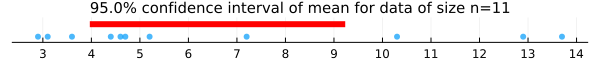

In [49]:
plot_confint_of_mean(x; α)

この図の区間を見ると, 一瞬

　データを示す青丸達のかなりの部分が区間をはみ出している!
 
と思ってしまいがちだが, この区間はデータの分布の範囲を表す区間ではなく, モデルの分布の平均パラメータ $\mu$ に関する区間であることを思い出せばこれで問題ないことがわかる.

以下の図のようにサンプルサイズ $n$ を大きくすれば, 平均の信頼区間の幅は狭くなる.

サンプルサイズ $n$ を $a$ 倍すると信頼区間の幅はおおよそ $\sqrt{a}$ 分の $1$ になる.

In [50]:
Random.seed!(4649373)
dist = Gamma(5,3)
x = rand(dist, 640)
a, b = extrema(x)
xlim = (a - 0.05(b - a), b + 0.05(b-a))

(0.6804657464956572, 44.56206635799026)

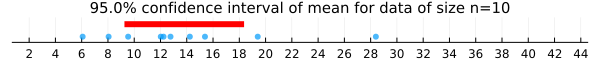

In [51]:
plot_confint_of_mean(x[1:10]; xlim, xtick=0:2:100)

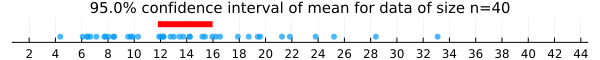

In [52]:
plot_confint_of_mean(x[1:40]; xlim, xtick=0:2:100)

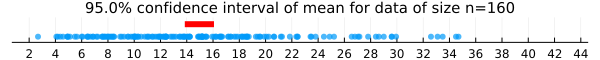

In [53]:
plot_confint_of_mean(x[1:160]; xlim, xtick=0:2:100)

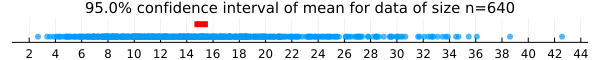

In [54]:
plot_confint_of_mean(x; xlim, xtick=0:2:100)

P値函数も同時にプロットすると以下のようになる.

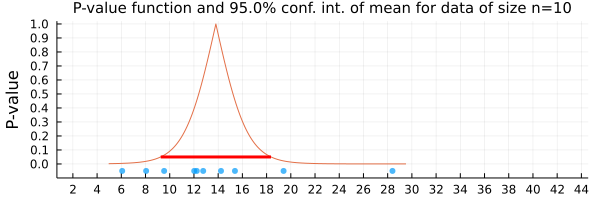

In [55]:
plot_confint_of_mean(x[1:10]; xlim, xtick=0:2:100, plot_pvalues=true)

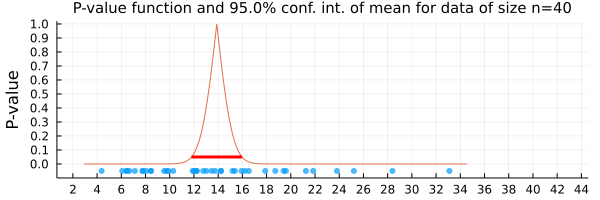

In [56]:
plot_confint_of_mean(x[1:40]; xlim, xtick=0:2:100, plot_pvalues=true)

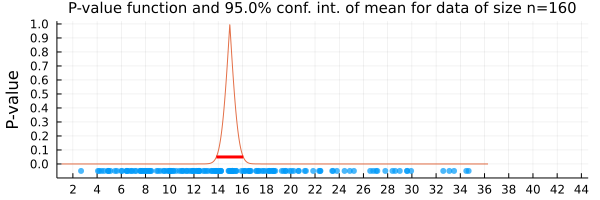

In [57]:
plot_confint_of_mean(x[1:160]; xlim, xtick=0:2:100, plot_pvalues=true)

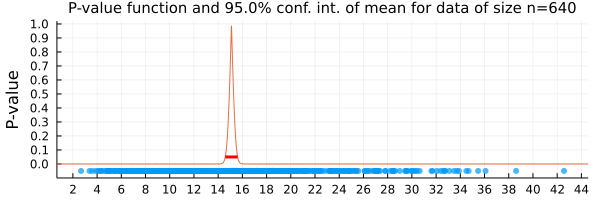

In [58]:
plot_confint_of_mean(x; xlim, xtick=0:2:100, plot_pvalues=true)

#### R言語での平均に関するP値と信頼区間の計算例

```R
x = c(13.7, 12.9, 4.4, 5.2, 3.1, 2.9, 7.2, 10.3, 4.7, 4.6, 3.6)
n = length(x)
xbar = mean(x)
s2 = var(x)
mu = 9
t.value = (xbar - mu)/sqrt(s2/n)
p.value = 2*(1 - pt(abs(t.value), n-1))
alpha = 0.05
c = qt(1 - alpha/2, n-1)
conf.int = c(xbar - c*sqrt(s2/n), xbar + c*sqrt(s2/n))

cat("data: x = ", x, "\n")
cat("data size n = ", n, "\n")
cat("sample mean of data = ", xbar, "\n")
cat("unbiased variance of data = ", s2, "\n")
cat("\n")
cat("t.value = ", t.value, "\n")
cat("p.value = ", p.value, "\n")
cat("\n")
cat("alpha = ", alpha, "\n")
cat("t_{alpha/2, n-1} = ", c, "\n")
cat("conf.int = ", conf.int, "\n")
```

以下のようにすれば一発で計算できる:

```R
t.test(c(13.7, 12.9, 4.4, 5.2, 3.1, 2.9, 7.2, 10.3, 4.7, 4.6, 3.6), mu=9)
```

In [59]:
R"""
x = c(13.7, 12.9, 4.4, 5.2, 3.1, 2.9, 7.2, 10.3, 4.7, 4.6, 3.6)
n = length(x)
xbar = mean(x)
s2 = var(x)
mu = 9
t.value = (xbar - mu)/sqrt(s2/n)
p.value = 2*(1 - pt(abs(t.value), n-1))
alpha = 0.05
c = qt(1 - alpha/2, n-1)
conf.int = c(xbar - c*sqrt(s2/n), xbar + c*sqrt(s2/n))

cat("data: x = ", x, "\n")
cat("data size n = ", n, "\n")
cat("sample mean of data = ", xbar, "\n")
cat("unbiased variance of data = ", s2, "\n")
cat("\n")
cat("t.value = ", t.value, "\n")
cat("p.value = ", p.value, "\n")
cat("\n")
cat("alpha = ", alpha, "\n")
cat("t_{alpha/2, n-1} = ", c, "\n")
cat("conf.int = ", conf.int, "\n")
""";

data: x =  13.7 12.9 4.4 5.2 3.1 2.9 7.2 10.3 4.7 4.6 3.6 
data size n =  11 
sample mean of data =  6.6 
unbiased variance of data =  15.35 

t.value =  -2.031671 
p.value =  0.06960994 

alpha =  0.05 
t_{alpha/2, n-1} =  2.228139 
conf.int =  3.967914 9.232086 


In [60]:
R"""
t.test(c(13.7, 12.9, 4.4, 5.2, 3.1, 2.9, 7.2, 10.3, 4.7, 4.6, 3.6), mu=9)
"""

RObject{VecSxp}

	One Sample t-test

data:  c(13.7, 12.9, 4.4, 5.2, 3.1, 2.9, 7.2, 10.3, 4.7, 4.6, 3.6)
t = -2.0317, df = 10, p-value = 0.06961
alternative hypothesis: true mean is not equal to 9
95 percent confidence interval:
 3.967914 9.232086
sample estimates:
mean of x 
      6.6 



### 必修練習問題: 平均に関するP値と信頼区間の計算

次のサイズ $20$ データとして次が与えられているとする:

>38.1, 28.9, 30.4, 27.6, 38.0, 35.3, 30.0, 29.3, 32.9, 34.8,<br>
39.4, 38.4, 28.4, 27.0, 35.9, 30.7, 28.2, 33.2, 33.0, 36.0

以上で説明した方法が以下を求めよ.

(1) 「平均は $\mu = 30.0$ である」という仮説のP値.

(2) 平均の $99\%$ 信頼区間.

まずは, この問題よりも上の方にある説明だけを見て(これより下の方を見ないで), 計算してみよ.

自力で計算した結果がぴったり正解になっていれば爽快な気分を味わえるだろう.

#### WaolframAlphaによる必修練習問題の解き方

`mean(38.1, 28.9, ... 36.0)` → [実行](https://www.wolframalpha.com/input?i=mean%2838.1%2C+28.9%2C+30.4%2C+27.6%2C+38.0%2C+35.3%2C+30.0%2C+29.3%2C+32.9%2C+34.8%2C+39.4%2C+38.4%2C+28.4%2C+27.0%2C+35.9%2C+30.7%2C+28.2%2C+33.2%2C+33.0%2C+36.0%29) → 32.775

`var(38.1, 28.9, ... 36.0)` → [実行](https://www.wolframalpha.com/input?i=var%2838.1%2C+28.9%2C+30.4%2C+27.6%2C+38.0%2C+35.3%2C+30.0%2C+29.3%2C+32.9%2C+34.8%2C+39.4%2C+38.4%2C+28.4%2C+27.0%2C+35.9%2C+30.7%2C+28.2%2C+33.2%2C+33.0%2C+36.0%29) → 16.1588

√(s²/n) の計算: `sqrt(16.1588/20)` → [実行](https://www.wolframalpha.com/input?i=sqrt%2816.1588%2F20%29) → 0.898855

t値の計算: `(32.775 - 30)/0.898855` → [実行](https://www.wolframalpha.com/input?i=%2832.775+-+30%29%2F0.898855) → 3.087261

P値の計算: `2(1 - cdf(TDistribution(19), 3.087261))` → [実行](https://www.wolframalpha.com/input?i=2%281+-+cdf%28TDistribution%2819%29%2C+3.087261%29%29) → ??????

$\alpha = 0.01$, $n-1=19$ のときの $t_{\alpha/2,n-1}$ の計算: `quantile(TDistribution(19), 0.995)` → [実行](https://www.wolframalpha.com/input?i=quantile%28TDistribution%2819%29%2C+0.995%29) → 2.86093

99%信頼区間の計算: `32.775-2.86093*0.898855, 32.775+2.86093*.898855` → [実行](https://www.wolframalpha.com/input?i=32.775-2.86093*0.898855%2C+32.775%2B2.86093*.898855) → ??????

#### Julia言語による必修練習問題の解き方

ほぼ定義通りの式をJulia言語のコードとして書けば計算できる.

```julia
function pvalue_tdist(x̄, s², n, μ)
    t = (x̄ - μ)/√(s²/n)
    2ccdf(TDist(n-1), abs(t))
end

function pvalue_tdist(x, μ)
    x̄, s², n = mean(x), var(x), length(x)
    pvalue_tdist(x̄, s², n, μ)
end

function confint_tdist(x̄, s², n; α = 0.05)
    c = quantile(TDist(n-1), 1-α/2)
    [x̄ - c*√(s²/n), x̄ + c*√(s²/n)]
end

function confint_tdist(x; α = 0.05)
    x̄, s², n = mean(x), var(x), length(x)
    confint_tdist(x̄, s², n; α)
end

function show_confint_of_mean(x; μ = mean(x), α = 0.05)
    println("(P-value of hypothesis \"mean = $μ\") = ", pvalue_tdist(x, μ))
    println("($(100(1-α))% confidence interval of mean) = ", confint_tdist(x; α))
end
```

`plot_confint_of_mean(x; α, plot_pvalues)` の定義についてはこのノートの最初の方を見よ.

(P-value of hypothesis "mean = 30.0") = 0.006064850644067268
(99.0% confidence interval of mean) = [30.203433862887117, 35.34656613711288]


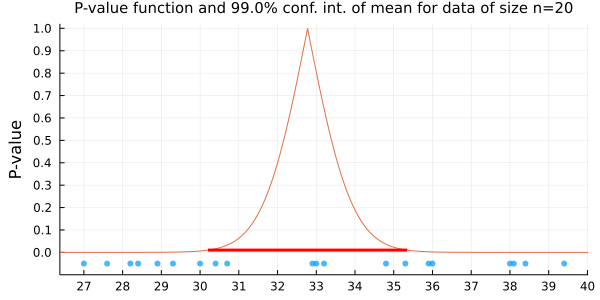

In [61]:
x = [38.1, 28.9, 30.4, 27.6, 38.0, 35.3, 30.0, 29.3, 32.9, 34.8,
    39.4, 38.4, 28.4, 27.0, 35.9, 30.7, 28.2, 33.2, 33.0, 36.0]
show_confint_of_mean(x; μ=30.0, α=0.01)
plot_confint_of_mean(x; α=0.01, plot_pvalues=true, size=(600, 300))

#### R言語による必修練習問題の解き方

R言語のインストール直後にすでに使えるようになっている `t.test` 函数一発で欲しい情報が得られる.

```R
x = c(38.1, 28.9, 30.4, 27.6, 38.0, 35.3, 30.0, 29.3, 32.9, 34.8,
    39.4, 38.4, 28.4, 27.0, 35.9, 30.7, 28.2, 33.2, 33.0, 36.0)
t.test(x, mu=30, conf.level=0.99)
```

実際に統計分析を行う場合にはこのような道具を使った方がよいだろう.

しかし, 統計学の仕組みを勉強する過程では, 計算の過程がわかるような勉強の仕方をした方がよいだろう.

In [62]:
R"""
x = c(38.1, 28.9, 30.4, 27.6, 38.0, 35.3, 30.0, 29.3, 32.9, 34.8,
    39.4, 38.4, 28.4, 27.0, 35.9, 30.7, 28.2, 33.2, 33.0, 36.0)
t.test(x, mu=30, conf.level=0.99)
"""

RObject{VecSxp}

	One Sample t-test

data:  x
t = 3.0873, df = 19, p-value = 0.006065
alternative hypothesis: true mean is not equal to 30
99 percent confidence interval:
 30.20343 35.34657
sample estimates:
mean of x 
   32.775 



#### 必修練習問題解答例

以下の程度の精度で報告すれば十分過ぎるほど十分である.

(1) P値 ≈ 0.006065

(2) 99%信頼区間 ≈ \[30.20, 35.35\]